In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


In [2]:
df = pd.read_csv("/content/indian_liver_patient.csv")

df.head()


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [6]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())


Shape: (583, 11)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB
None


In [4]:
# Fill missing Albumin_and_Globulin_Ratio with median
if "Albumin_and_Globulin_Ratio" in df.columns:
    df["Albumin_and_Globulin_Ratio"].fillna(df["Albumin_and_Globulin_Ratio"].median(), inplace=True)

# Encode Gender: Female = 0, Male = 1
df["Gender"] = df["Gender"].map({"Female": 0, "Male": 1})

# Encode Target: in this dataset, 'Dataset' is usually 1 = disease, 2 = no disease
df["Dataset"] = df["Dataset"].replace({2: 0, 1: 1})

print(df["Dataset"].value_counts())
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64


In [5]:
df.describe(include="all")

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,583,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,44.746141,NaN,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,NaN,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,NaN,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,NaN,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,NaN,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,NaN,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000


In [7]:
# Fill missing Albumin_and_Globulin_Ratio with median
if "Albumin_and_Globulin_Ratio" in df.columns:
    df["Albumin_and_Globulin_Ratio"].fillna(df["Albumin_and_Globulin_Ratio"].median(), inplace=True)

# Encode Gender: Female = 0, Male = 1
df["Gender"] = df["Gender"].map({"Female": 0, "Male": 1})

# Encode Target: in this dataset, 'Dataset' is usually 1 = disease, 2 = no disease
df["Dataset"] = df["Dataset"].replace({2: 0, 1: 1})

print(df["Dataset"].value_counts())


Dataset
1    416
0    167
Name: count, dtype: int64


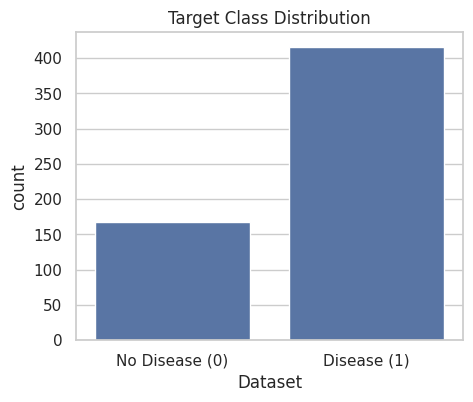

In [8]:
plt.figure(figsize=(5,4))
sns.countplot(x="Dataset", data=df)
plt.xticks([0,1], ["No Disease (0)", "Disease (1)"])
plt.title("Target Class Distribution")
plt.show()


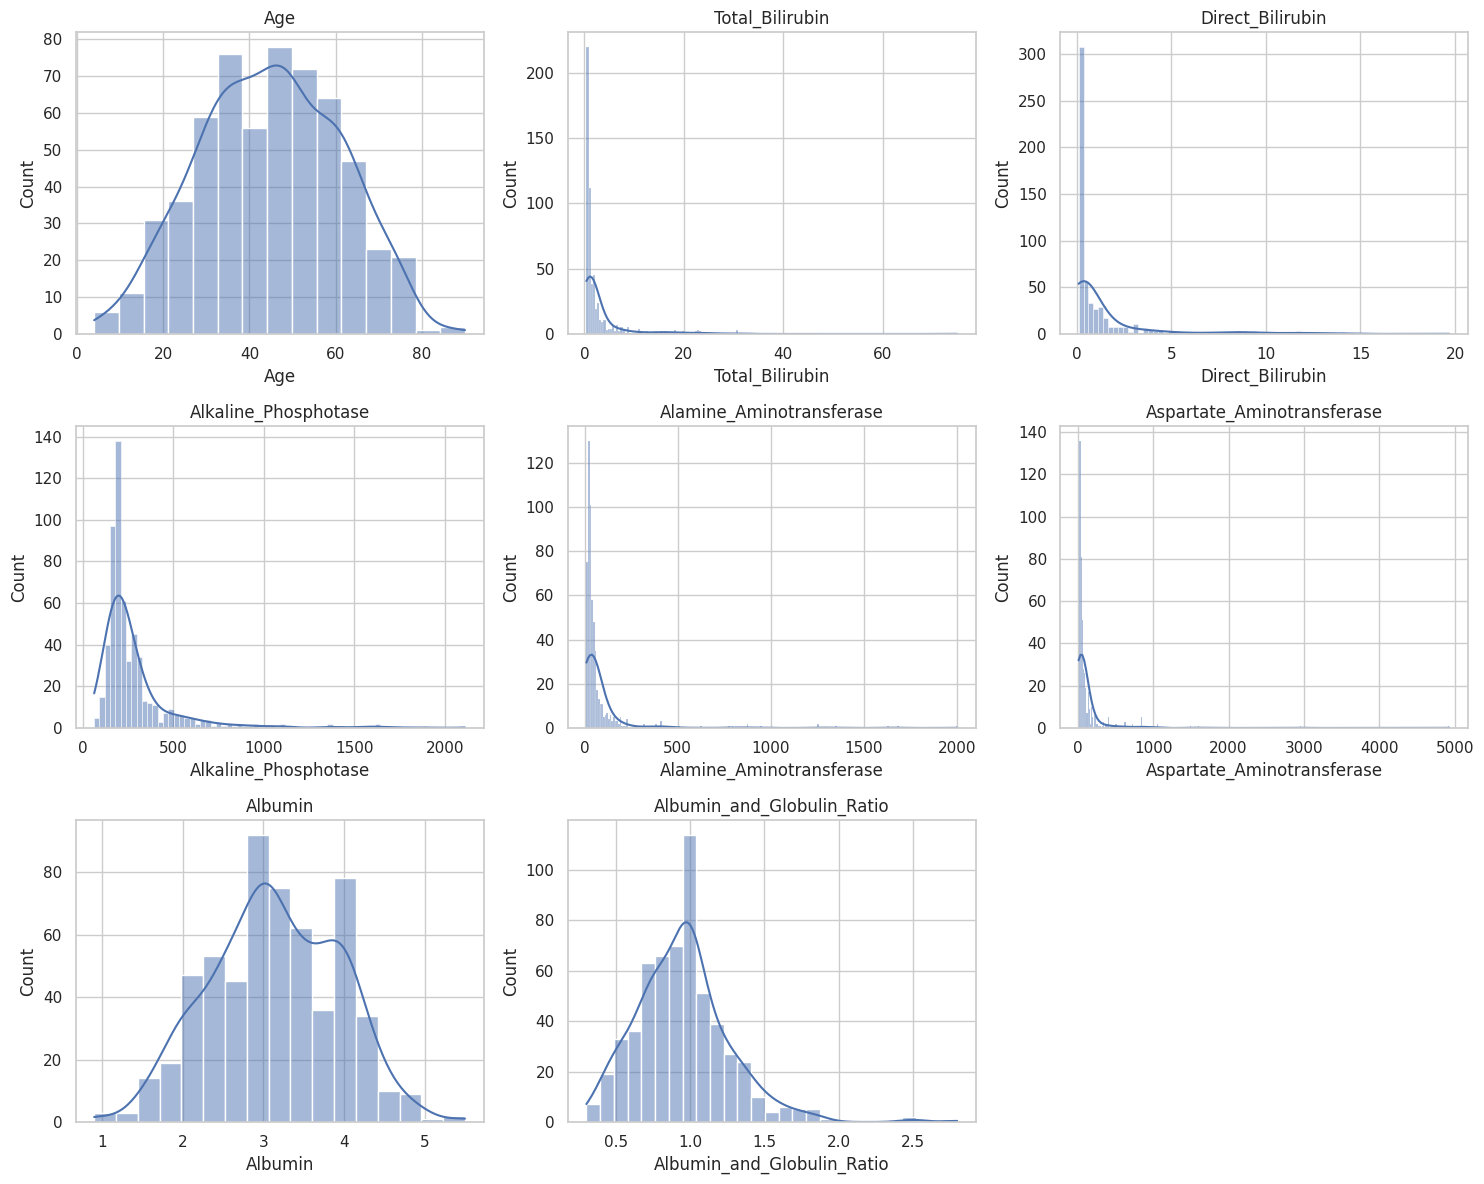

In [10]:
import math

num_cols = [
    "Age", "Total_Bilirubin", "Direct_Bilirubin",
    "Alkaline_Phosphotase", "Alamine_Aminotransferase",
    "Aspartate_Aminotransferase", "Total_Proteins",
    "Albumin", "Albumin_and_Globulin_Ratio"
]

# Filter only columns that exist in dataframe
num_cols = [col for col in num_cols if col in df.columns]

# Define subplot grid size
n_cols = 3  # number of plots per row
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(15, 12))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.tight_layout()

plt.show()


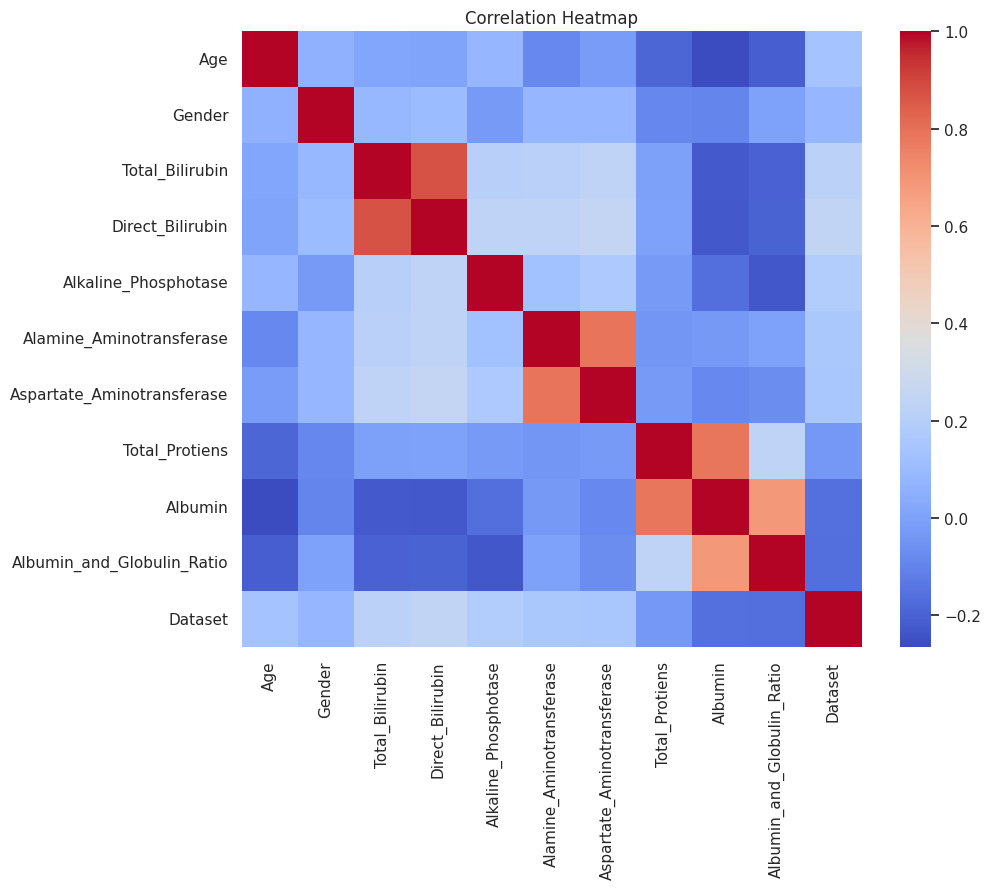

In [11]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [12]:
X = df.drop("Dataset", axis=1)
y = df["Dataset"]

X.head(), y.head()


(   Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
 0   65       0              0.7               0.1                   187   
 1   62       1             10.9               5.5                   699   
 2   62       1              7.3               4.1                   490   
 3   58       1              1.0               0.4                   182   
 4   72       1              3.9               2.0                   195   
 
    Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
 0                        16                          18             6.8   
 1                        64                         100             7.5   
 2                        60                          68             7.0   
 3                        14                          20             6.8   
 4                        27                          59             7.3   
 
    Albumin  Albumin_and_Globulin_Ratio  
 0      3.3                        0.90  


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, X_test.shape


((466, 10), (117, 10))

In [14]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    )
}

results = {}

for name, model in models.items():
    if name in ["Logistic Regression"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:,1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results[name] = {"Accuracy": acc, "ROC-AUC": auc}

results


{'Logistic Regression': {'Accuracy': 0.7350427350427351,
  'ROC-AUC': np.float64(0.8306165839829908)},
 'Random Forest': {'Accuracy': 0.7350427350427351,
  'ROC-AUC': np.float64(0.7434443656980865)},
 'XGBoost': {'Accuracy': 0.7008547008547008,
  'ROC-AUC': np.float64(0.7278525868178597)}}

In [15]:
results_df = pd.DataFrame(results).T
results_df


,Accuracy,ROC-AUC
Logistic Regression,0.735043,0.830617
Random Forest,0.735043,0.743444
XGBoost,0.700855,0.727853


In [16]:
best_model_name = results_df["ROC-AUC"].idxmax()
print("Best Model based on ROC-AUC:", best_model_name)

best_model = models[best_model_name]


Best Model based on ROC-AUC: Logistic Regression


Accuracy: 0.7350427350427351
ROC-AUC: 0.8306165839829908

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.18      0.28        34
           1       0.74      0.96      0.84        83

    accuracy                           0.74       117
   macro avg       0.70      0.57      0.56       117
weighted avg       0.72      0.74      0.68       117



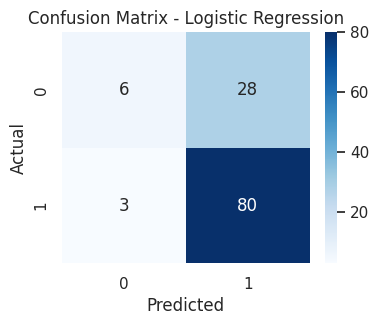

In [17]:
if best_model_name == "Logistic Regression":
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:,1]
else:
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


In [18]:
risk_scores = pd.DataFrame({
    "Actual": y_test.values,
    "Risk_Score": y_proba
})

risk_scores.head()


,Actual,Risk_Score
0,1,0.841712
1,1,0.718372
2,0,0.731476
3,1,0.863423
4,1,0.730965


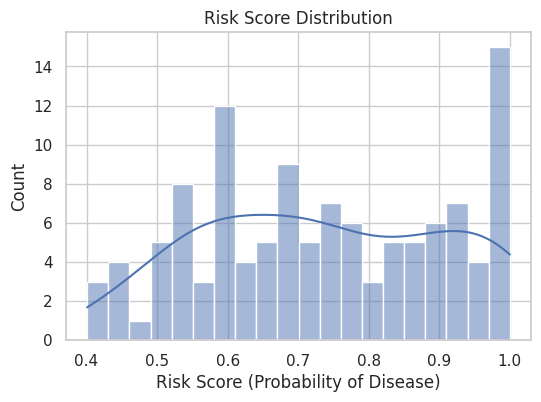

In [19]:
plt.figure(figsize=(6,4))
sns.histplot(risk_scores["Risk_Score"], bins=20, kde=True)
plt.title("Risk Score Distribution")
plt.xlabel("Risk Score (Probability of Disease)")
plt.ylabel("Count")
plt.show()


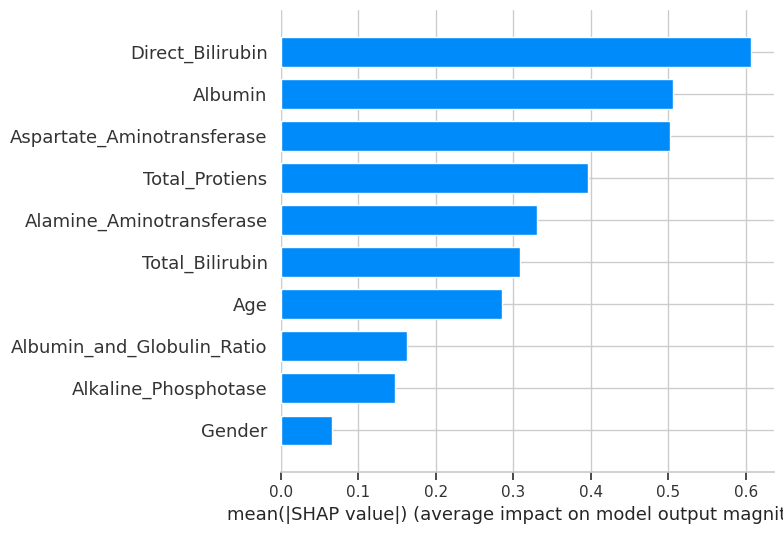

In [21]:
import shap

X_explain = pd.DataFrame(X_test_scaled, columns=X.columns)

if best_model_name in ["Random Forest", "XGBoost"]:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_explain)

elif best_model_name == "Logistic Regression":
    explainer = shap.LinearExplainer(best_model, X_explain)
    shap_values = explainer.shap_values(X_explain)

# For both cases:
shap.summary_plot(shap_values, X_explain, plot_type="bar")


In [22]:
df.columns

Index(['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Dataset'],
      dtype='object')

In [23]:
import joblib

# 1️⃣ Save the best model
joblib.dump(best_model, "liver_disease_risk_model.pkl")

# 2️⃣ Save the feature column names (so Streamlit uses the same order)
joblib.dump(list(X.columns), "liver_feature_columns.pkl")

# 3️⃣ Save the scaler (only because we used StandardScaler earlier)
joblib.dump(scaler, "liver_scaler.pkl")

print("Saved: liver_disease_risk_model.pkl, liver_feature_columns.pkl, liver_scaler.pkl")


Saved: liver_disease_risk_model.pkl, liver_feature_columns.pkl, liver_scaler.pkl
